In [1]:
import numpy as np

import lapgm
import view_utils
import brainweb_utils

# Data Acquisition
We will be using a variant of the *BrainWeb* dataset for our debiasing example. Example data will be downloaded once into the examples/data subfolder.

In [2]:
# Download and read BrainWeb normal data
brainweb_dict = brainweb_utils.get_biased_data()

brainweb_data = [brainweb_dict['T1'], brainweb_dict['T2'], brainweb_dict['PD']]

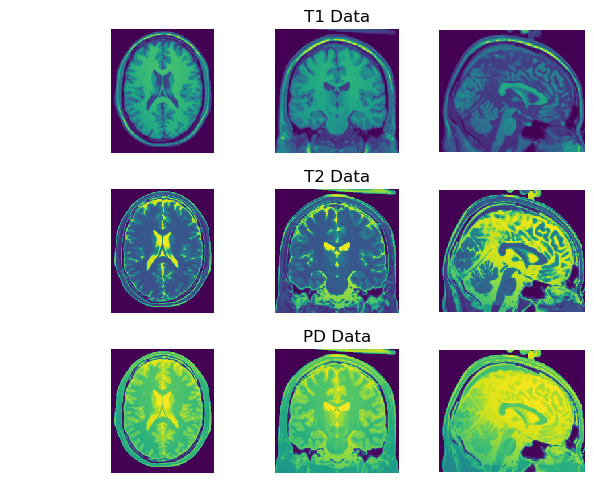

In [3]:
# Associated label data
class_data = brainweb_utils.download_and_read_phantom()
data_mask = class_data > 0

# View center slices of the BrainWeb dataset
view_utils.view_center_slices(brainweb_data, data_mask, ['T1 Data', 'T2 Data', 'PD Data'])

# Debias Setup and Run
LapGM can be run either on the CPU or GPU if appropriate packages are installed. Next cell specifies whether GPU compute should be used.

In [4]:
# Skip or comment out if GPU is not available
lapgm.use_gpu(True)

Next we set up the LapGM object by specifying settings and hyperparameters for the run.

In [5]:
# Computation can be saved by specifying a downscaling factor.
debias_obj = lapgm.LapGM(downscale_factor=2)

# -- Specify hyperparameters --
# tau is an inverse regularization strength on the estimated bias gradient
# n_classes specifies the number of tissue classes visible (including ambient space)
# log_initialize initializes clusters with log transform. Increases sensitivity to finding clusters
#     of similar intensity. For less dispersed bias fields it may be better to set to true.
debias_obj.set_hyperparameters(tau=5e-5, n_classes=6, log_initialize=False)

# Cast datatype and attach relevant sequence information
brainweb_arr = lapgm.to_sequence_array([brainweb_dict['T1'], brainweb_dict['T2'], brainweb_dict['PD']])

In [6]:
# Run debias procedure and take parameter output
params = debias_obj.estimate_parameters(brainweb_arr, print_tols=True)

iter: 0, Bdiff: inf
iter: 1, Bdiff: 0.44309915523010224
iter: 2, Bdiff: 0.18490323122176355
iter: 3, Bdiff: 0.08153903170011308
iter: 4, Bdiff: 0.04740432288782879
iter: 5, Bdiff: 0.03047537111970186
iter: 6, Bdiff: 0.018829228835165777
iter: 7, Bdiff: 0.012967441534228212
iter: 8, Bdiff: 0.009544871789604285
iter: 9, Bdiff: 0.00733957850173183
iter: 10, Bdiff: 0.005784356019129871
iter: 11, Bdiff: 0.004658550155250535
iter: 12, Bdiff: 0.0037606054506891546
iter: 13, Bdiff: 0.0030181736211989055
iter: 14, Bdiff: 0.0024061198265137823
iter: 15, Bdiff: 0.0019626772396993016
iter: 16, Bdiff: 0.0016315935051268503
iter: 17, Bdiff: 0.0013514966110454467
iter: 18, Bdiff: 0.0011117954700456917
iter: 19, Bdiff: 0.0009299973987840982
iter: 20, Bdiff: 0.0008260079643042768
iter: 21, Bdiff: 0.000663874484164038
iter: 22, Bdiff: 0.0007104403115520838
iter: 23, Bdiff: 0.0007211869396307714
iter: 24, Bdiff: 0.0009416189952381452


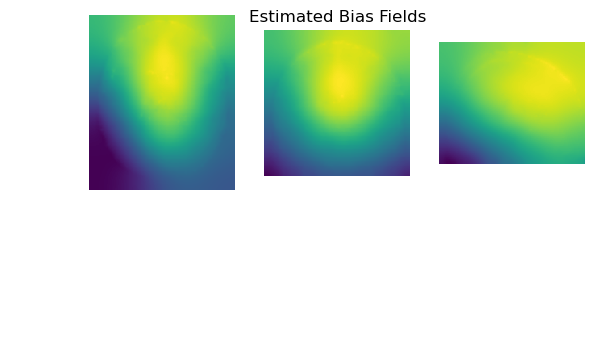

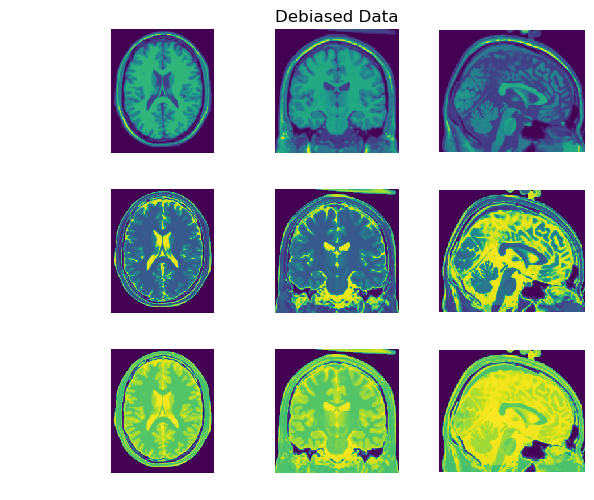

In [7]:
# View estimated bias field
view_utils.view_center_slices(np.exp(params.B), title_names=['Estimated Bias Fields'])

# Debias data
brainweb_deb = lapgm.debias(brainweb_arr, params)
# View debiased result
view_utils.view_center_slices(brainweb_deb, data_mask, ['Debiased Data', None, None])

A total of six classes were used in estimation while ten are provided in the ground truth phantom. As the number of classes increases, estimation becomes more difficult. This can be offset by estimating directly on the non-downsample data with tau value decreased accordingly.

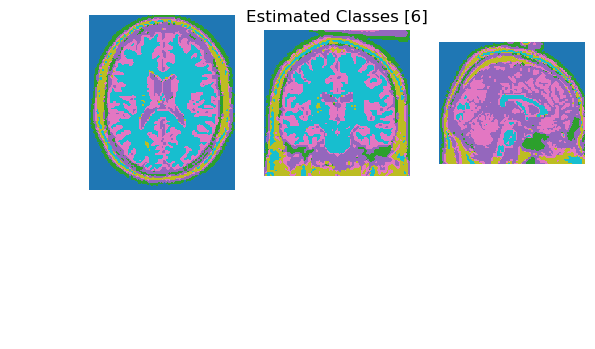

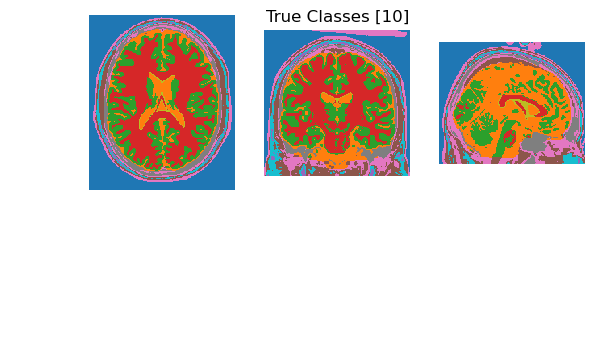

In [8]:
# 6 Class LapGM esimation with order dictacted by T1 means for consistent labels
view_utils.view_class_map(params.w, order=np.argsort(params.mu[:,0]), title_name='Estimated Classes [6]')

# 10 Class BrainWeb phantom
view_utils.view_center_slices(class_data, cmap_name='tab10', title_names=['True Classes [10]'])

# MR Normalization
It is possible that, across multiple MR scans, there will be slight variations in the intensity scalings of different MR images. To correct for this LapGM can normalize intensity values against prominent or bright tissue groups

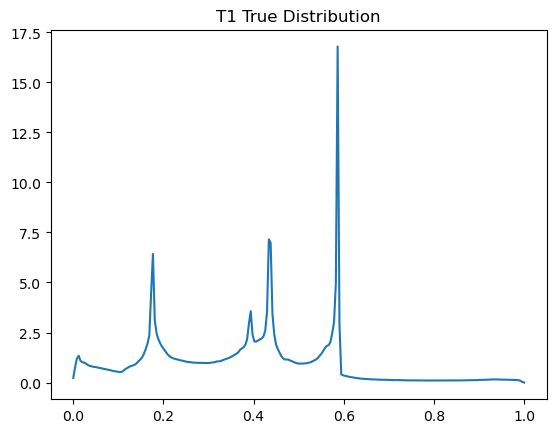

In [9]:
# Get clean BrainWeb T1 data
clean_t1 = brainweb_utils.download_and_read_normal(noise=0, rf_intensity=0)['T1']
view_utils.view_distributions(clean_t1, bandwidth=1e-2, mask_volume=data_mask,
                              title_name='T1 True Distribution')

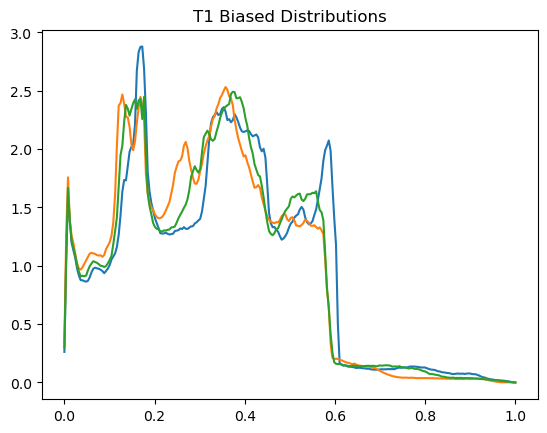

In [10]:
# Gather differently biased examples
brainweb_dict_ex0 = brainweb_dict
brainweb_dict_ex1 = brainweb_utils.get_biased_data(bias_example_id=1)
brainweb_dict_ex2 = brainweb_utils.get_biased_data(bias_example_id=2)

# View intensity distributions of each example
t1_biased_coll = [brainweb_dict_ex0['T1'], brainweb_dict_ex1['T1'], brainweb_dict_ex2['T1']]
view_utils.view_distributions(t1_biased_coll, bandwidth=1e-2, mask_volume=data_mask, 
                              title_name='T1 Biased Distributions')

First setup and debias the examples 1 and 2.

In [11]:
# Relabel example 0
params_ex0 = params
brainweb_deb_ex0 = brainweb_deb

# Cast example 1 data to sequence array and then run debias
brainweb_arr_ex1 = lapgm.to_sequence_array([brainweb_dict_ex1['T1'], 
                                            brainweb_dict_ex1['T2'], 
                                            brainweb_dict_ex1['PD']])

print('Example 1:')
params_ex1 = debias_obj.estimate_parameters(brainweb_arr_ex1, print_tols=True)
brainweb_deb_ex1 = lapgm.debias(brainweb_arr_ex1, params_ex1)

# Cast example 2 data to sequence array and then run debias
brainweb_arr_ex2 = lapgm.to_sequence_array([brainweb_dict_ex2['T1'], 
                                            brainweb_dict_ex2['T2'], 
                                            brainweb_dict_ex2['PD']])

print('\nExample 2:')
params_ex2 = debias_obj.estimate_parameters(brainweb_arr_ex2, print_tols=True)
brainweb_deb_ex2 = lapgm.debias(brainweb_arr_ex2, params_ex2)

Example 1:
iter: 0, Bdiff: inf
iter: 1, Bdiff: 0.4877405631596939
iter: 2, Bdiff: 0.21510018905833234
iter: 3, Bdiff: 0.12405020922435854
iter: 4, Bdiff: 0.07535344935209609
iter: 5, Bdiff: 0.04810269137982649
iter: 6, Bdiff: 0.03325860576931348
iter: 7, Bdiff: 0.023525861082648016
iter: 8, Bdiff: 0.01722000759286168
iter: 9, Bdiff: 0.013135843866453677
iter: 10, Bdiff: 0.010294533302287351
iter: 11, Bdiff: 0.008198114398829559
iter: 12, Bdiff: 0.006664172505227082
iter: 13, Bdiff: 0.0054643107857270225
iter: 14, Bdiff: 0.004499553466396685
iter: 15, Bdiff: 0.0037392951218521387
iter: 16, Bdiff: 0.003080951903901228
iter: 17, Bdiff: 0.0024881711840581207
iter: 18, Bdiff: 0.0018732931725093244
iter: 19, Bdiff: 0.001546838281910997
iter: 20, Bdiff: 0.0014544527363867484
iter: 21, Bdiff: 0.001397929061345794
iter: 22, Bdiff: 0.0013492191106781594
iter: 23, Bdiff: 0.0013419162745391582
iter: 24, Bdiff: 0.0014456507896938799

Example 2:
iter: 0, Bdiff: inf
iter: 1, Bdiff: 0.4081412162843629

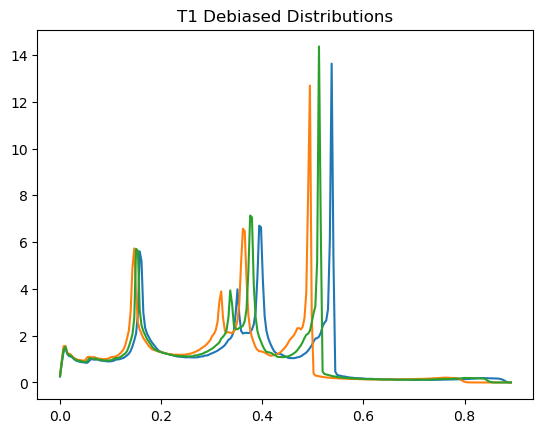

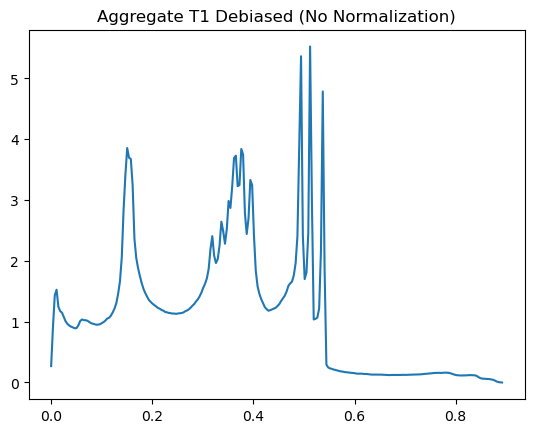

In [12]:
# View debiased intensity distributions
t1_debiased_coll = [brainweb_deb_ex0[0], brainweb_deb_ex1[0], brainweb_deb_ex2[0]]
view_utils.view_distributions(t1_debiased_coll, bandwidth=1e-2, mask_volume=data_mask, 
                              title_name='T1 Debiased Distributions')

# See the aggregate T1 distribution with no normalization
view_utils.view_distributions(t1_debiased_coll, bandwidth=1e-2, mask_volume=data_mask, combine=True,
                              title_name='Aggregate T1 Debiased (No Normalization)')

Without an absolute scaling we can get good per patient intensity recovery but incorrect aggregate distribution recovery. To fix this we will normalize each debiased image to the largest estimated class mean. 

Ideally this should match the farthest peak of the original true distribution which is at about 0.6 intensity. Note that below the peaks have broadened due to small differences in the estimated means. However both the number of peaks and their height order has been preserved by the normalization.

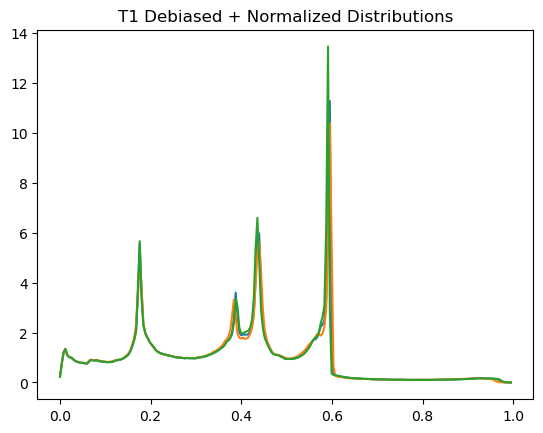

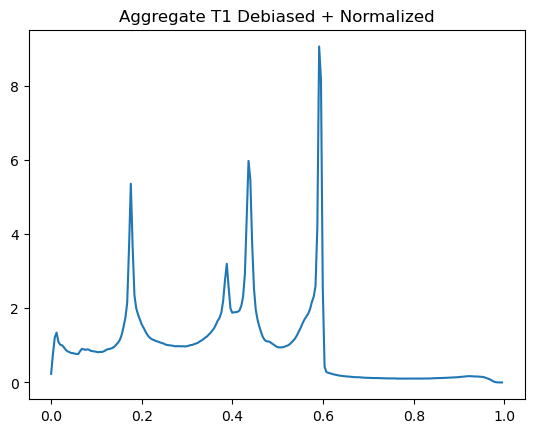

In [13]:
# Approximate location of farthest peak for true data.
# In practice this can be set to any fixed value of choice.
TRGT = 0.6

# Normalize the 3 examples
brainweb_norm_ex0 = lapgm.normalize(brainweb_deb_ex0, params_ex0, target_intensity=TRGT)
brainweb_norm_ex1 = lapgm.normalize(brainweb_deb_ex1, params_ex1, target_intensity=TRGT)
brainweb_norm_ex2 = lapgm.normalize(brainweb_deb_ex2, params_ex2, target_intensity=TRGT)

# View normalized intensity distributions
t1_normalized_coll = [brainweb_norm_ex0[0], brainweb_norm_ex1[0], brainweb_norm_ex2[0]]
view_utils.view_distributions(t1_normalized_coll, bandwidth=1e-2, mask_volume=data_mask, 
                              title_name='T1 Debiased + Normalized Distributions')

# Now try viewing the aggregate distribution using normalized data
view_utils.view_distributions(t1_normalized_coll, bandwidth=1e-2, mask_volume=data_mask, combine=True,
                              title_name='Aggregate T1 Debiased + Normalized')